In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision as tv
import torchvision.datasets as dset
import torchvision.transforms as T
from torchvision import tv_tensors  # we'll describe this a bit later, bare with us

import torchvision.datasets as datasets
from pathlib import Path

from torchview import draw_graph
from pathlib import Path

import constants
import dataset
import util
import json
import pandas as pd
import models 
from models import VQANet
import matplotlib.pyplot as plt
import numpy as np
import time
import gc
from datetime import datetime

from transformers import AutoTokenizer
import traceback

USE_GPU = True
dtype = torch.float32 # We will be using float throughout this tutorial.

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():      
    device = 'mps'                         
else:
    device = torch.device('cpu')


print('using device:', device)
    



using device: mps


In [ ]:
foz.load_zoo_dataset("coco-2014", split = 'test')

In [2]:

%load_ext autoreload
%autoreload 2

In [11]:

def show(imgs):
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = T.ToPILImage()(img.to('cpu'))
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])


In [4]:
# with open(constants.CAPTION_TRAIN, 'r') as f:
#     data = json.load(f)
#     print(data.keys())
#     print(data["annotations"][0])

# with open(constants.VQA_OPEN_ENDED_QUESTION_TRAIN, 'r') as f:
#     data = json.load(f)
#     print(data.keys())
#     print(data["questions"][0])

# with open(constants.VQA_OPEN_ENDED_ANSWER_TRAIN, 'r') as f:
#     data = json.load(f)
#     print(data.keys())
#     print(data["annotations"][0])
    
# with open(constants.CAPTION_VAL, 'r') as f:
#     data = json.load(f)
#     print(data.keys())

# with open(constants.VQA_OPEN_ENDED_QUESTION_VAL, 'r') as f:
#     data = json.load(f)
#     print(data.keys())

# with open(constants.VQA_OPEN_ENDED_ANSWER_VAL, 'r') as f:
#     data = json.load(f)
#     print(data.keys())

#dataset.load(constants.VQA_OPEN_ENDED_QUESTION_TRAIN, ['image_id', 'id', 'caption'])

In [16]:
train = dataset.Coco()
# val = dataset.Coco("validation")
# test = dataset.Coco("test")

Found annotations at '/Users/xiangyuliu/sources/fiftyone_dataset_zoo/coco-2017/raw/instances_train2017.json'
Images already downloaded
Existing download of split 'train' is sufficient
Loading existing dataset 'coco-2017-train'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


In [17]:
print(len(train))
print(len(train.captions))
# print(len(test.questions))

118287
591753


q/a: What is in front of the giraffes? tree
q/a: What do these giraffes have in common? eating
q/a: Could this photo be from a zoo? yes
q/a: Are the animals eating? yes
q/a: Where is the giraffe? near tree
q/a: Is there a zebra? no
q/a: What is the giraffe standing behind? tree
q/a: Is the giraffe eating the tree? yes
q/a: Are both giraffes standing? no
q/a: Are they at a zoo? yes
q/a: What is on the ground next to the giraffe on the right? log
q/a: Are some of the trees dead? yes
q/a: Are any of the animals eating? yes
q/a: Is the giraffe in the shade? no
q/a: Are these giraffes living free range? yes
q/a: How many giraffes are there? 2
q/a: Is there a rock near the giraffe? no
q/a: How many animals are in this photo? 2


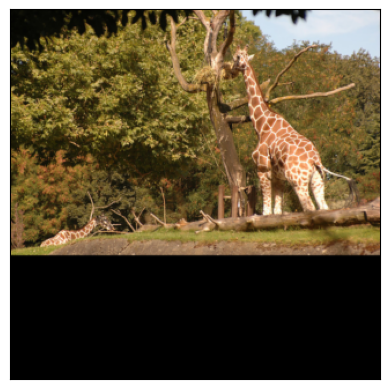

In [20]:
if True: # debug
    img = train.__getitem__(1)
#     print(img)
#     print(img.image_id)
#     print(img.image_path)

#     print(">>>>")
#     print(img.captions())

#     print(">>>>")
#     print(img.qa())


    show([img.image_tensor(device)])
    qa_len = len(img.annotations['raw_qs'])
    for i in range(qa_len):
        print(f"q/a: {img.annotations['raw_qs'][i]} {img.annotations['raw_anses'][i]}")
#    plt.imshow(  img.image_tensor().permute(1, 2, 0)  )


In [8]:
tokenizer  = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")
# Add the Q and A token as special token
tokenizer.add_special_tokens(constants.QA_TOKEN_DICT)

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


4

In [9]:
from imagedata import get_image

def path_to_image(paths, device):
    result = []
    for p in paths:
        result.append(get_image(path, device))
    image = torch.stack(result, dim = 0).to(device)
    print("image shape", image.shape)
    return image
    
def collate_fn2(batch):
    result = {}
    
    result['image_ids'] = []
    result['image_paths'] = []
    result['c2i'] = [] # index for images for a given caption. same len as 'caption'
    result['qa2i'] = [] # index of corresponding image for a given qa. same len as 'qa'
    result['q_id'] = [] # id of the questions 'qa'
    
    
    target  = [] # the corresponding target for the qa.
    raw_captions = []  # plain text 
    raw_qa = []   # plain text
    raw_qids = []   # question ids
    for idx, data in enumerate(batch):
        result['image_ids'].append(data.image_id)
        result['image_paths'].append(data.image_path)
        caption_list = data.captions()
        if caption_list is not None:
            raw_captions += caption_list
            for c in range(len(caption_list)):
                result['c2i'].append(idx)
        
        qa_list = data.qa()
        q_id_list = data.qids()
        if qa_list is not None:
            raw_qa += qa_list
            raw_qids += q_id_list
            for c in range(len(qa_list)):
                result['qa2i'].append(idx)
    #print("raw_cap", len(raw_captions))
    #print("raw_qa", len(raw_qa))
    
    result['raw_cap'] = raw_captions
    result['captions'] = None if len(raw_captions) == 0 else \
                                tokenizer(raw_captions, padding='max_length',truncation=True,  max_length=32, return_tensors="pt").to(device)
#    print('captions:', result['captions'])
    result['raw_qa'] = raw_qa
    result['qids'] = raw_qids
    if len(raw_qa) != 0:
#        print("raw_qa:", raw_qa)
        result['qa'] =  tokenizer(raw_qa, padding='max_length', truncation=True, max_length=32, return_tensors="pt")['input_ids'].to(device, dtype=torch.int64)
#        print('qa:', result['qa'])

        end_padding = torch.broadcast_to(torch.zeros(1), (result['qa'].shape[0], 1)).to(device, dtype=torch.int64)
        #print(end_padding.shape)
        # return a shape {seq, batch}
        target = torch.column_stack((result['qa'][:, 1:], end_padding)).transpose(0, 1)
    else:
        result['qa'] = None
        target = None
    return result, target


In [10]:
from torch.utils.data import DataLoader
batch_size = 32
fn = collate_fn2 
shuffle = False  # True
train_dataloader = DataLoader(train, batch_size=batch_size, shuffle=shuffle, collate_fn=fn)
# val_dataloader = DataLoader(val, batch_size=batch_size, shuffle=shuffle, collate_fn=fn)
# test_dataloader = DataLoader(test, batch_size=batch_size, shuffle=shuffle, collate_fn=fn)

In [11]:
def spot_check(dataloader, size=5):
    it = iter(dataloader)
    for _ in range(size):
        x, target= next(it)
        print(x)
        show(x["images"])

In [12]:
# spot_check(train_dataloader)

In [13]:
# spot_check(test_dataloader)

In [14]:
ce_fn = nn.CrossEntropyLoss( reduction='none')
cos_fn = nn.CosineSimilarity(dim=1)

In [15]:
# out = model(x, device)
# image_embedding, captions_embeddings, output_logits = out
# print(captions_embeddings.shape)
# a = output_logits.reshape(-1, len(tokenizer))
# b = target.reshape(-1)
# print("a", a.shape, a)
# print("b", b.shape, b)

# ce_loss = ce_fn(a, b)
# print(ce_loss.shape)
# N = len(x['images'])
# M = len(x['qa2i'])
# ce = ce_loss.reshape(-1, M).transpose(0, 1)
# print(ce.shape)
# print(ce)
# per_qa  = torch.mean(ce, axis = 1)
# print(per_qa.shape)

In [16]:
# blown = models.blow_to(image_embedding, result['c2i'])
# print(image_embedding.shape)
# print(image_embedding)
# print(blown.shape)
# print(blown)
# print("captions_embedding:", captions_embeddings.shape)
# print(result['c2i'])

In [17]:
# print(blown)
# print(captions_embeddings)
# cos= nn.CosineSimilarity(dim = 0)
# print(cos(blown[1], captions_embeddings[1]))

# per_caption_loss = cos_fn(blown, captions_embeddings)
# print(per_caption_loss)
# per_image_caption_loss = cal_average(len(result['images']), per_caption_loss, result['c2i'])
# print(per_image_caption_loss.shape)

# print(per_image_caption_loss)

In [18]:
def reload_model(lr, name, use_captions):
    model = VQANet(tokenizer, use_captions).to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    if name is not None:
        checkpoint = torch.load(constants.MODEL_OUT_PATH.joinpath(name))
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        model.to(device)
    return model, optimizer

def save_model(model, optimizer, name):
    print("saving model to ", name)
    torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()},
        constants.MODEL_OUT_PATH.joinpath(name))

In [19]:
def cal_average(size, blown_loss, replicas):
    result= torch.zeros(size).to(device)
    counts = torch.zeros(size).to(device)
    for index, val in enumerate(replicas):
        result[val] += blown_loss[index]
        counts[val] += 1
        
    for index in range(size):
        if counts[index] == 0:
            counts[index] = 1  # so that result / counts still makes sense.
    #print("result", result)
    #print("counts:", counts)
    counts = counts.detach()  # we don't need gradient for the counts.
    result /= counts
    return result

In [20]:
import gc
DEBUG = False
def do_train(model, optimizer, idx, x, target, gamma, should_print = False):
        N = len(x['image_ids'])
        # Zero your gradients for every batch!
        optimizer.zero_grad()
        if DEBUG:
            image_embedding_for_captions, captions_embedding, output_logits = None, None, None
        else:
            image_embedding_for_captions, captions_embedding, output_logits  = model(x, device)

        if output_logits is None and captions_embedding is None:
            return torch.tensor(0).to(device)
#        image_embedding, captions_embedding, output_logits = None, None, None
        per_image_qa_loss = None
        per_image_caption_loss = None
        
        if output_logits is not None:
#            print("out_logits argmax", torch.argmax(output_logits.transpose(0,1), axis=2))
#            print("target", target)
            a = output_logits.reshape(-1, len(tokenizer))

            b = target.reshape(-1)
#            print("a", a.shape)
#            print("b", b.shape)

            K = len(x['qa2i'])
            # back to (K, seq)
            qa_loss = ce_fn(a, b).reshape(-1, K).transpose(0, 1)
            #print("qa_loss", qa_loss.shape)
            # qa loss, shape of (K) (different images can have diff counts of qas)
            per_qa_loss = torch.mean(qa_loss, axis = 1)

            # per image qa loss, shape of (N)
            per_image_qa_loss = cal_average(N, per_qa_loss, x['qa2i'])
            per_image_qa_loss = torch.sum(per_image_qa_loss)
            #print("per_qa_loss", per_qa_loss.shape)
            #print("per_image_qa_loss", per_image_qa_loss.shape)

        if captions_embedding is not None:
            # loss per caption, shape of (M) (different images can have diff counts of captions)
            per_caption_loss = cos_fn(image_embedding_for_captions, captions_embedding)
            # cosine similarity is within [-1, 1] where 1 being similar. 
            # for loss, we invert it and shift it by 1 to keep the value always positive.
            # thus 0 means similar, 2 means completely opposite
            # print("per_captions_loss:", per_caption_loss)
            per_caption_loss = -per_caption_loss + 1
            # print("normalized per_captions_loss:", per_caption_loss)
            # per image loss on the caption scale. shape of (N)
            per_image_caption_loss = cal_average(N, per_caption_loss, x['c2i'])
            per_image_caption_loss = torch.sum(per_image_caption_loss)

        total_loss = 0
        if per_image_caption_loss is not None:
            total_loss += gamma * per_image_caption_loss
            
        if per_image_qa_loss is not None:
            total_loss += per_image_qa_loss

        loss = torch.sum(total_loss)

        if not DEBUG:
            loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

        return per_image_caption_loss, per_image_qa_loss, loss
            
def training(run_name, writer, epoches, use_caption, gamma, early_terminate = None, save_model_every = None,
             sync_after_every_n = 200, print_every = 100, lr = 0.1):
    model, optimizer = reload_model(lr, None, use_caption)
    
    model_name = 'train-' + run_name
    step = 0
    model.train()
    for epoch_idx in range(epoches):
        epoch_start_time = time.time()

        print ("----- Start Epoch %s -----" % epoch_idx)
        epoch_loss = 0
        for idx, (x, target) in enumerate(train_dataloader):
            batch_start_time = time.time()
            step += 1
            name = model_name + f"-epoch-{epoch_idx}-batch-{idx}"

            should_print = print_every is not None and (print_every == 1 or idx % (print_every -1) == 0)
            if should_print:
                print(">>>> Batch # ", idx,  x['image_ids'] )
            if early_terminate is not None:
                if idx > early_terminate - 1:
                    print("early terminating. at ", idx)
                    break;
            try:
                per_image_caption_loss, per_image_qa_loss, loss = \
                       do_train(model, optimizer, idx, x, target, gamma, should_print)
                if per_image_caption_loss is not None:
                    per_image_caption_loss = per_image_caption_loss.detach().item()
                if per_image_qa_loss is not None:
                    per_image_qa_loss = per_image_qa_loss.detach().item()
                loss = loss.detach()
                batch_loss = loss.item()
            except Exception as e:
                print(">>>> FAILED! Batch # ", idx,  x['image_ids'])
                print(f"current mps allocated memory: {torch.mps.current_allocated_memory()}")
                print(f"current mps driver allocated memory: {torch.mps.driver_allocated_memory()}")
                name = model_name + f"-failed-with-memory-epoch-{epoch_idx}-batch-{idx}"
                save_model(model, optimizer, name)
                traceback.print_exc()
                return model;

            model_saved = False
            if save_model_every is not None and (idx + 1) % save_model_every == 0:
                save_model(model, optimizer, name)
                model_saved = True
                
            if sync_after_every_n is not None and (idx + 1) % sync_after_every_n == 0:
                print("=========== mps sync, gc, and mps empty cache and reload ==========")
                print(f"current mps allocated memory: {torch.mps.current_allocated_memory()}")
                print(f"current mps driver allocated memory: {torch.mps.driver_allocated_memory()}")

                if model_saved:
                    print("Clearing references")
                    del model
                    del loss
                    del optimizer
                gc.collect()
                torch.mps.synchronize()
                torch.mps.empty_cache()
                torch.mps.synchronize()
                print("after empyt cache")
                print(f"current mps allocated memory: {torch.mps.current_allocated_memory()}")
                print(f"current mps driver allocated memory: {torch.mps.driver_allocated_memory()}")
                if model_saved: 
                    print("Reloading model")
                    model, optimizer = reload_model(lr, name, use_caption)
                    model.train()


            if should_print:
                print("loss:", batch_loss)
                print("--- %s Per batch time ---" % (time.time() - batch_start_time))
            
            if writer is not None:
                writer.add_scalar("Time/train Per Batch", (time.time() - batch_start_time), step)
                writer.add_scalar(f"Loss/train Per Batch", batch_loss, step)

                if per_image_qa_loss is not None:
                    writer.add_scalar(f"QA Loss/train Per Batch", per_image_qa_loss, step)

                if per_image_caption_loss is not None:
                    writer.add_scalar(f"Caption Loss/train Per Batch", per_image_caption_loss, step)
            epoch_loss += batch_loss

        epoch_loss /= len(train_dataloader) if early_terminate is None \
                                            else (early_terminate * train_dataloader.batch_size)
        
        if writer is not None:
            writer.add_scalar("Loss/train", epoch_loss, epoch_idx)

        print(f"---DONE: {epoch_idx} epoch, {(time.time() - epoch_start_time)} seconds, loss {epoch_loss} ---")
        save_model(model, optimizer, model_name)
    return model
    

In [21]:
# vqa with caption is trained
if False:
    from torch.utils.tensorboard import SummaryWriter
    
    gamma = 0.9
    current_time = datetime.now().strftime("%b%d_%H-%M-%S")
    run_name = "vqa_with_caption_" + current_time
    writer = SummaryWriter(Path.joinpath(constants.TB_OUT_PATH, run_name))

    #model = training(run_name, None, 40, use_caption = True, gamma = gamma, \
    #                 sync_after_every_n=None, print_every = 1,  early_terminate = 10)
    model = training(run_name, writer, 1, use_caption = True, gamma = gamma,
                    sync_after_every_n=50, save_model_every = 150, print_every = 10,  early_terminate = None)
    writer.flush()


In [22]:
# vqa with adam 
if True:
    from torch.utils.tensorboard import SummaryWriter
    def reload_model(lr, name, use_captions):
        model = VQANet(tokenizer, use_captions).to(device)
        optimizer = optim.Adam(model.parameters(), lr=1e-3)
        if name is not None:
            checkpoint = torch.load(constants.MODEL_OUT_PATH.joinpath(name))
            model.load_state_dict(checkpoint['model_state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            model.to(device)
        return model, optimizer

    def save_model(model, optimizer, name):
        print("saving model to ", name)
        torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()},
            constants.MODEL_OUT_PATH.joinpath(name))
    
    gamma = 0.9
    current_time = datetime.now().strftime("%b%d_%H-%M-%S")
    run_name = "vqa_with_caption_adam_" + current_time
    writer = SummaryWriter(Path.joinpath(constants.TB_OUT_PATH, run_name))

    #model = training(run_name, None, 40, use_caption = True, gamma = gamma, \
    #                 sync_after_every_n=None, print_every = 1,  early_terminate = 10)
    model = training(run_name, writer, 1, use_caption = True, gamma = gamma,
                    sync_after_every_n=50, save_model_every = 150, print_every = 10,  early_terminate = None,
                    lr = 0.001)
    writer.flush()

----- Start Epoch 0 -----
>>>> Batch #  0 [9, 25, 30, 34, 36, 42, 49, 61, 64, 71, 72, 73, 74, 77, 78, 81, 86, 89, 92, 94, 109, 110, 113, 127, 133, 136, 138, 142, 143, 144, 149, 151]


/Users/xiangyuliu/sources/pytorch/torch/nn/functional.py:4072: UserWarning: The operator 'aten::_upsample_bilinear2d_aa.out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/xiangyuliu/sources/pytorch/aten/src/ATen/mps/MPSFallback.mm:13.)
  return torch._C._nn._upsample_bilinear2d_aa(input, output_size, align_corners, scale_factors)


loss: 300.2248229980469
--- 4.0730881690979 Per batch time ---
>>>> Batch #  9 [1401, 1403, 1404, 1407, 1408, 1424, 1431, 1436, 1442, 1448, 1451, 1453, 1455, 1464, 1472, 1488, 1496, 1497, 1501, 1505, 1507, 1510, 1515, 1518, 1522, 1523, 1525, 1526, 1527, 1536, 1548, 1554]
loss: 82.63390350341797
--- 4.464992046356201 Per batch time ---
>>>> Batch #  18 [2896, 2902, 2907, 2931, 2951, 2963, 2964, 2972, 2982, 2983, 2985, 2988, 2989, 2992, 2998, 3000, 3001, 3003, 3008, 3014, 3035, 3040, 3048, 3067, 3076, 3077, 3080, 3084, 3091, 3093, 3103, 3109]
loss: 70.48611450195312
--- 9.275784015655518 Per batch time ---
>>>> Batch #  27 [4537, 4546, 4549, 4551, 4554, 4555, 4567, 4571, 4574, 4575, 4576, 4578, 4579, 4587, 4592, 4595, 4608, 4616, 4620, 4622, 4624, 4642, 4647, 4662, 4665, 4673, 4678, 4684, 4688, 4694, 4700, 4702]
loss: 75.87845611572266
--- 8.238209962844849 Per batch time ---
>>>> Batch #  36 [5906, 5907, 5913, 5915, 5916, 5917, 5933, 5934, 5946, 5947, 5961, 5962, 5965, 5967, 5991, 5994,

loss: 66.32051849365234
--- 1.946669101715088 Per batch time ---
>>>> Batch #  225 [35105, 35107, 35110, 35123, 35126, 35127, 35128, 35132, 35145, 35146, 35148, 35150, 35156, 35160, 35176, 35190, 35195, 35206, 35210, 35211, 35216, 35217, 35222, 35228, 35230, 35240, 35241, 35242, 35245, 35246, 35248, 35256]
loss: 61.452369689941406
--- 2.201211929321289 Per batch time ---
>>>> Batch #  234 [36482, 36484, 36487, 36488, 36492, 36498, 36500, 36501, 36503, 36508, 36522, 36523, 36528, 36533, 36542, 36544, 36546, 36547, 36548, 36557, 36559, 36561, 36563, 36567, 36569, 36574, 36589, 36598, 36605, 36606, 36607, 36614]
loss: 49.684967041015625
--- 2.6528871059417725 Per batch time ---
>>>> Batch #  243 [37958, 37968, 37973, 37979, 37986, 37999, 38000, 38017, 38022, 38026, 38027, 38029, 38030, 38031, 38033, 38034, 38041, 38046, 38049, 38053, 38055, 38064, 38073, 38079, 38083, 38090, 38092, 38097, 38116, 38117, 38122, 38123]
loss: 58.858543395996094
--- 2.0403828620910645 Per batch time ---
======

loss: 63.69822311401367
--- 2.0933282375335693 Per batch time ---
>>>> Batch #  432 [67697, 67704, 67715, 67716, 67726, 67727, 67729, 67742, 67748, 67749, 67752, 67757, 67761, 67765, 67768, 67771, 67776, 67779, 67785, 67786, 67788, 67792, 67798, 67802, 67805, 67807, 67814, 67823, 67832, 67833, 67835, 67837]
loss: 55.9781608581543
--- 1.9693470001220703 Per batch time ---
>>>> Batch #  441 [69081, 69087, 69117, 69121, 69136, 69140, 69145, 69148, 69163, 69167, 69169, 69182, 69188, 69189, 69194, 69196, 69197, 69200, 69205, 69209, 69214, 69215, 69220, 69223, 69226, 69229, 69231, 69236, 69242, 69252, 69256, 69257]
loss: 68.63459777832031
--- 1.982306957244873 Per batch time ---
saving model to  train-vqa_with_caption_adam_Jun04_17-44-09-epoch-0-batch-449
=========== mps sync, gc, and mps empty cache and reload ==========
current mps allocated memory: 3164499456
current mps driver allocated memory: 31160762368
Clearing references
after empyt cache
current mps allocated memory: 577536
current

loss: 67.07290649414062
--- 1.9846341609954834 Per batch time ---
>>>> Batch #  639 [100407, 100409, 100413, 100417, 100430, 100434, 100435, 100438, 100439, 100448, 100449, 100454, 100468, 100471, 100482, 100483, 100485, 100486, 100499, 100500, 100503, 100506, 100516, 100517, 100519, 100523, 100530, 100535, 100536, 100539, 100542, 100543]
loss: 65.30403137207031
--- 1.9934790134429932 Per batch time ---
>>>> Batch #  648 [101839, 101842, 101860, 101862, 101863, 101873, 101874, 101877, 101882, 101891, 101892, 101894, 101895, 101904, 101906, 101913, 101919, 101931, 101933, 101936, 101948, 101951, 101952, 101959, 101960, 101966, 101968, 101969, 101978, 101979, 101985, 101989]
loss: 60.72292709350586
--- 2.151103973388672 Per batch time ---
=========== mps sync, gc, and mps empty cache and reload ==========
current mps allocated memory: 3157433856
current mps driver allocated memory: 30888722432
after empyt cache
current mps allocated memory: 3157433856
current mps driver allocated memory:

loss: 62.689029693603516
--- 1.959486961364746 Per batch time ---
>>>> Batch #  828 [129956, 129957, 129971, 129977, 129980, 129982, 129988, 129989, 129995, 130000, 130005, 130006, 130007, 130011, 130017, 130024, 130030, 130032, 130037, 130043, 130047, 130053, 130062, 130065, 130069, 130070, 130074, 130076, 130081, 130088, 130093, 130096]
loss: 63.522605895996094
--- 2.1043801307678223 Per batch time ---
>>>> Batch #  837 [131416, 131418, 131419, 131427, 131434, 131449, 131450, 131453, 131460, 131465, 131467, 131470, 131485, 131486, 131487, 131490, 131493, 131494, 131497, 131498, 131504, 131509, 131511, 131516, 131522, 131524, 131527, 131531, 131533, 131534, 131539, 131547]
loss: 60.33832550048828
--- 1.9468176364898682 Per batch time ---
>>>> Batch #  846 [132826, 132836, 132838, 132841, 132847, 132850, 132857, 132860, 132861, 132874, 132878, 132883, 132887, 132888, 132889, 132901, 132902, 132908, 132913, 132935, 132944, 132946, 132953, 132954, 132959, 132964, 132972, 132973, 132982, 

loss: 59.71908950805664
--- 1.9687209129333496 Per batch time ---
>>>> Batch #  1017 [159761, 159763, 159768, 159771, 159774, 159777, 159790, 159808, 159820, 159823, 159828, 159831, 159832, 159842, 159850, 159854, 159856, 159880, 159887, 159888, 159889, 159897, 159898, 159900, 159923, 159924, 159926, 159929, 159944, 159948, 159952, 159953]
loss: 64.63703155517578
--- 2.3018438816070557 Per batch time ---
>>>> Batch #  1026 [161054, 161056, 161060, 161062, 161071, 161079, 161083, 161084, 161093, 161098, 161101, 161112, 161121, 161124, 161129, 161141, 161144, 161156, 161157, 161161, 161163, 161169, 161178, 161185, 161187, 161190, 161193, 161195, 161202, 161218, 161220, 161222]
loss: 42.36390686035156
--- 2.0460288524627686 Per batch time ---
>>>> Batch #  1035 [162558, 162559, 162561, 162573, 162577, 162578, 162579, 162580, 162584, 162589, 162592, 162596, 162598, 162627, 162634, 162641, 162643, 162645, 162646, 162650, 162654, 162675, 162677, 162682, 162685, 162688, 162691, 162692, 162693

>>>> Batch #  1206 [189882, 189884, 189885, 189888, 189893, 189903, 189912, 189915, 189919, 189922, 189924, 189932, 189936, 189939, 189943, 189949, 189951, 189955, 189957, 189966, 189975, 189982, 189983, 189993, 189996, 189997, 189998, 190000, 190002, 190013, 190014, 190015]
loss: nan
--- 1.959505319595337 Per batch time ---
>>>> Batch #  1215 [191251, 191261, 191262, 191264, 191265, 191270, 191277, 191280, 191283, 191293, 191296, 191297, 191298, 191300, 191301, 191304, 191305, 191310, 191314, 191320, 191321, 191325, 191327, 191329, 191332, 191334, 191338, 191340, 191342, 191350, 191353, 191359]
loss: nan
--- 2.003403902053833 Per batch time ---
>>>> Batch #  1224 [192692, 192701, 192702, 192707, 192710, 192714, 192720, 192722, 192723, 192730, 192744, 192745, 192747, 192755, 192759, 192763, 192764, 192768, 192774, 192780, 192782, 192787, 192788, 192793, 192795, 192796, 192798, 192799, 192804, 192806, 192808, 192809]
loss: nan
--- 2.063202142715454 Per batch time ---
>>>> Batch #  1233 

>>>> Batch #  1404 [221521, 221523, 221524, 221532, 221533, 221536, 221540, 221542, 221543, 221546, 221547, 221554, 221555, 221557, 221560, 221561, 221562, 221565, 221571, 221578, 221587, 221592, 221593, 221597, 221605, 221609, 221610, 221614, 221615, 221616, 221618, 221620]
loss: nan
--- 1.9743258953094482 Per batch time ---


KeyboardInterrupt: 

In [ ]:
# vqa no caption is trained
if False:
    from torch.utils.tensorboard import SummaryWriter
    
    gamma = 0.9
    current_time = datetime.now().strftime("%b%d_%H-%M-%S")
    run_name = "vqa_no_caption_" + current_time
    writer = SummaryWriter(Path.joinpath(constants.TB_OUT_PATH, run_name))

    model = training(run_name, writer, 1, use_caption = False, gamma = gamma,
                    sync_after_every_n=50, save_model_every = 150, print_every = 20,  early_terminate = 1400)
    
#     model = training(run_name, writer, 1, use_caption = False, gamma = gamma,
#                     sync_after_every_n=50, save_model_every = 1, print_every = 2,  early_terminate = 1400)
    writer.flush()

In [ ]:
# vqa with 0.5 caption
if False:
    from torch.utils.tensorboard import SummaryWriter
    
    gamma = 0.5
    current_time = datetime.now().strftime("%b%d_%H-%M-%S")
    run_name = "vqa_with_0_5_caption_" + current_time
    writer = SummaryWriter(Path.joinpath(constants.TB_OUT_PATH, run_name))

    model = training(run_name, writer, 1, use_caption = True, gamma = gamma,
                    sync_after_every_n=50, save_model_every = 150, print_every = 10,  early_terminate = 1400)
    writer.flush()

In [ ]:
def manual(dataset, size):
    items = []
    
    for i in range(size):
        item = dataset.__getitem__(i)
        # replace the `qa` with just the `qs`
        print(item.annotations['qa'])
        item.annotations['qa'] = item.annotations['qs']
        items.append(item)
    return collate_fn2(items)

In [ ]:
print(">>> original qa")
test1x, target = manual(val, 5)
model, optimizer = reload_model(0.01, "train-vqa_with_caption_Jun02_17-27-12-epoch-0-batch-1949", use_captions = True)
model.eval()
answers = model.answer(test1x, device, max_length = 30)

print(">>> prediction")
def token_to_word(x):
    qa = x["qa"]
    return tokenizer.batch_decode(qa)

token_to_word(answers)

In [ ]:
def get_answers(x):
    qa = x["qa"]
    answer_token_id = tokenizer.convert_tokens_to_ids(constants.ANSWER_TOKEN)

    answer_start =  (qa == answer_token_id).nonzero()
    mask = torch.zeros_like(qa)
    mask[answer_start[:, 0], answer_start[:, 1]] = 1
    # fill the elements after the [ANSWER] token to be 1.
    mask = mask.cumsum(dim=1)
    just_answers = qa * mask
    return tokenizer.batch_decode(just_answers, skip_special_tokens = True)
    
real_answers = get_answers(answers)

In [ ]:
def create_output(x, answers):
    result = []
    qids = x['qids']
    assert len(qids) == len(answers)
    for i in range(len(qids)):
        d = {"question_id" : qids[i], "answer": answers[i]}
        result.append(d)
    return result

In [ ]:
result = create_output(test1x, real_answers)
print(result)

In [ ]:
        
def run_validation(run_name, model, writter, early_terminate = None,
             sync_after_every_n = 200, print_every = 100):
    with torch.no_grad():
        model.eval()
        result = []
        step = 0
        for idx, (x, target) in enumerate(val_dataloader):
            step += 1
            should_print = print_every is not None and (print_every == 1 or idx % (print_every -1) == 0)
            if should_print:
                print(">>>> Batch # ", idx,  x['image_ids'] )
            if early_terminate is not None:
                if idx > early_terminate - 1:
                    print("early terminating. at ", idx)
                    break;
            image_embedding_for_captions, captions_embedding, output_logits = None, None, None

            try:
                N = len(x['image_ids'])
                image_embedding_for_captions, captions_embedding, output_logits  = model(x, device)
            except Exception as e:
                print(">>>> FAILED! Batch # ", idx,  x['image_ids'])
                print(f"current mps allocated memory: {torch.mps.current_allocated_memory()}")
                print(f"current mps driver allocated memory: {torch.mps.driver_allocated_memory()}")
                traceback.print_exc()
                
            per_image_qa_loss = None
            if output_logits is not None:

                a = output_logits.reshape(-1, len(tokenizer))

                b = target.reshape(-1)

                K = len(x['qa2i'])
                # back to (K, seq)
                qa_loss = ce_fn(a, b).reshape(-1, K).transpose(0, 1)
                #print("qa_loss", qa_loss.shape)
                # qa loss, shape of (K) (different images can have diff counts of qas)
                per_qa_loss = torch.mean(qa_loss, axis = 1)

                # per image qa loss, shape of (N)
                per_image_qa_loss = cal_average(N, per_qa_loss, x['qa2i'])
                per_image_qa_loss = torch.sum(per_image_qa_loss)
                #print("per_qa_loss", per_qa_loss.shape)
                #print("per_image_qa_loss", per_image_qa_loss.shape)

            total_loss = torch.tensor(0).to(device)
            if per_image_qa_loss is not None:
                total_loss += per_image_qa_loss

            loss = torch.sum(total_loss).detach().item()
            
            if sync_after_every_n is not None and (idx + 1) % sync_after_every_n == 0:
                print("=========== mps sync, gc, and mps empty cache and reload ==========")
                print(f"current mps allocated memory: {torch.mps.current_allocated_memory()}")
                print(f"current mps driver allocated memory: {torch.mps.driver_allocated_memory()}")
                gc.collect()
                torch.mps.synchronize()
                torch.mps.empty_cache()
                torch.mps.synchronize()
                print("after empyt cache")
                print(f"current mps allocated memory: {torch.mps.current_allocated_memory()}")
                print(f"current mps driver allocated memory: {torch.mps.driver_allocated_memory()}")
            
            if writer is not None:
                writer.add_scalar("Time/val Per Batch", (time.time() - batch_start_time), step)
                writer.add_scalar(f"Loss/val Per Batch", batch_loss, step)

                if per_image_qa_loss is not None:
                    writer.add_scalar(f"QA Loss/val Per Batch", per_image_qa_loss, step)

                if per_image_caption_loss is not None:
                    writer.add_scalar(f"Caption Loss/val Per Batch", per_image_caption_loss, step)
            

            if writer is not None:
                writer.add_scalar("Time/val Per Batch", (time.time() - batch_start_time), step)
                writer.add_scalar(f"Loss/val Per Batch", batch_loss, step)


            epoch_loss += batch_loss
        writer.add_scalar(f"Loss/val Epoch", epoch_loss, step)


In [ ]:
writer = SummaryWriter(Path.joinpath(constants.TB_OUT_PATH, "validation_sample"))

run_validation('validation_sample_run', model, writer, early_terminate= 10)

In [ ]:
import json

def run_test(name, model, early_terminate = None,
             sync_after_every_n = 200, print_every = 100):
    with torch.no_grad():
        model.eval()
        result = []
        for idx, (x, target) in enumerate(test_dataloader):
            step += 1
            should_print = print_every is not None and (print_every == 1 or idx % (print_every -1) == 0)
            if should_print:
                print(">>>> Batch # ", idx,  x['image_ids'] )
            if early_terminate is not None:
                if idx > early_terminate - 1:
                    print("early terminating. at ", idx)
                    break;
            image_embedding_for_captions, captions_embedding, output_logits = None, None, None

            try:
                answers = model.answer(x, device, max_length = 30)
                real_answers = get_answers(answers)
                out = create_output(x, real_answers)
                if should_print:
                    print(">>>> Batch # ", out)

                result += out
                if should_print:
                    print("result size:", len(result))

            except Exception as e:
                print(">>>> FAILED! Batch # ", idx,  x['image_ids'])
                print(f"current mps allocated memory: {torch.mps.current_allocated_memory()}")
                print(f"current mps driver allocated memory: {torch.mps.driver_allocated_memory()}")
                traceback.print_exc()
                return
                
            if sync_after_every_n is not None and (idx + 1) % sync_after_every_n == 0:
                print("=========== mps sync, gc, and mps empty cache and reload ==========")
                print(f"current mps allocated memory: {torch.mps.current_allocated_memory()}")
                print(f"current mps driver allocated memory: {torch.mps.driver_allocated_memory()}")
                gc.collect()
                torch.mps.synchronize()
                torch.mps.empty_cache()
                torch.mps.synchronize()
                print("after empyt cache")
                print(f"current mps allocated memory: {torch.mps.current_allocated_memory()}")
                print(f"current mps driver allocated memory: {torch.mps.driver_allocated_memory()}")

        data = json.loads(result)
        with open(constants.TEST_OUTPUT.joinpath(name), 'w') as f:
            json.dump(data, f)